# Catchment hydrological model with 5 parameters
In this Notebook we are going to use a hydrological model, run it and calibrate it to try to understand how it works.

Imagine that we want to predict the hydrograph of a river that collects water from a basin when it rains. For this purpose we use a hydrological model, which is nothing more than a set of equations that describe in a simplified way the hydrological processes that occur in the basin. These equations include different parameters that describe some of the properties of the basin, for example the characteristics of the soil.
![diagrama cuenca](util/diagrama_cuenca.gif)

In this example, we are going to use a simple model (an adaptation of the model [HyMOD](https://doi.org/10.1029/WS006)) which has 5 parameters:

- **Soil storage capacity** (mm): capacity of the soil to retain rainwater
- **Evaporation ratio**: evaporation ratio or proportion of rain that evaporates
- **Percolation ratio**: percolation ratio proportion of effective rainwater (that does not evaporate) that percolates into the ground.
- **Travel time - surface flow** (days): surface water concentration time or time it takes for surface water to reach the mouth of the basin.
- **Travel time - underground flow** (days): groundwater concentration time or time it takes for groundwater to reach the mouth of the basin.

In the image below we can see how the model represents the hydrological processes in order to finally obtain the prediction of the river's hydrograph for the coming months. As you can see, the soil is presented as a deposit with a certain capacity that, if exceeded, overflows, generating surface flow and that also displaces water through its lower part, generating groundwater.

![diagrama modelo hidrologico](util/Diagrama_modelo.gif)

The first thing, as always, is to import the function libraries that we are going to need.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from ipywidgets import interact

## Load data
We have observed daily rainfall (mm/day), potential evapotranspiration (mm/day) and outflow (m3/day) data from 2010 to 2019.

In [2]:
obs_data = pd.read_excel('datos/data example 2.xlsx',index_col = 'date')
obs_data # to print the data on screen

,rain,etp,outflow
date,,,
2010-01-01,1.270,1.168133,6531.84
2010-01-02,2.032,0.262242,6531.84
2010-01-03,25.654,0.991814,74995.20
2010-01-04,13.462,0.808446,33868.80
2010-01-05,24.638,0.849716,101606.40
...,...,...,...
2019-12-28,0.000,0.200841,9918.72
2019-12-29,0.000,0.738878,8951.04
2019-12-30,0.000,0.848909,8467.20


In [6]:
# Inputs
dates = obs_data_year.index
prec  = obs_data_year['rain']
etp   = obs_data_year['etp']



for t in range(1,T):

    ##### Effective rainfall (or rainfall excess) #####
    effec_rain[t] = max(sm[t-1] + prec[t] - sm_max, 0)
    
    ##### Temporary soil moisture #####
    sm_temp = max(min(sm[t-1] + prec[t], sm_max), 0)

    ##### Evapotranspiration #####
    W = min(np.abs(sm_temp/sm_max)*gamma, 1) # Factor de correccion de la evapotranspiracion
    et[t] = W * etp[t] # Calculo de la evapotranspiracion

    ##### Soil moisture at time t #####       
    sm[t] = max(min(sm[t-1] + prec[t] - et[t], sm_max), 0)

    ##### Subsurface flow  or baseflow######
    sL[t] = sL[t-1] + (alpha)*effec_rain[t] - q_sub[t-1]
    q_sub[t] = 1/t_sub * sL[t]
    
    ##### Surface flow or runoff #####
    sF[t] = sF[t-1] +  (1-alpha)*effec_rain[t] - q_sur[t-1]
    q_sur[t] = 1/t_sur * sF[t]
    
Q_sub = q_sub * 0.001 * A
Q_sur = q_sur * 0.001 * A

##### Total simulated flow or outflow #####
    
Q_sim = Q_sur + Q_sub

### Visualization of the results
Now we can see the result of the simulation, in this case we represent the surface flow, the underground flow and the total hydrograph (sum of the two)

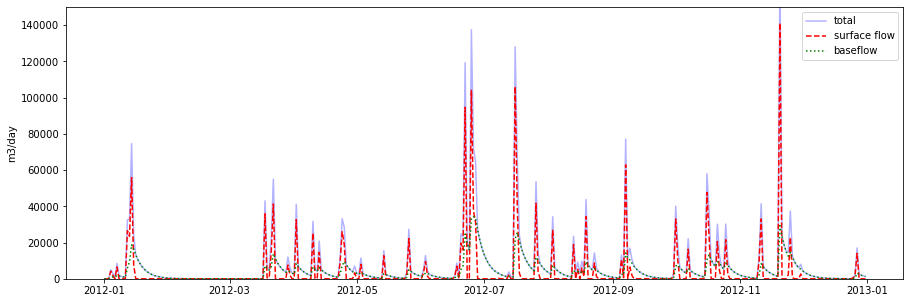

In [7]:
plt.figure(figsize=(15,5))
plt.plot(dates,Q_sim, label = 'total',color = 'blue', alpha = 0.3)
plt.plot(dates,Q_sur, linestyle = '--', color = 'red',   label = 'surface flow')
plt.plot(dates,Q_sub, linestyle = ':',  color = 'green', label = 'baseflow')
plt.ylim(0,150000) # to define the limits of the y axis
plt.legend()
plt.ylabel('m3/day')
plt.show()

If we now want to repeat the simulation but with different values of the parameters to check how the result changes, we would need to go back to the "Model Parameters" cell, manually change the values and run the subsequent cells again until the hydrograph graph is generated and repeat this process over and over... It doesn't sound very efficient. Let's do something different.

### Interactive hydrological model
In order to understand the influence of the model parameters on the result we are going to make our model more interactive using widgets, and more specifically sliders. Now we are going to create a `hydrologic_model` function that will contain our hydrologic model and through the `interact` function of the Ipwidgets library we will be able to interact with the model parameters more easily.

In [8]:
@interact(sm_max = (10, 90, 1), gamma = (0.01, 0.99, 0.01), alpha = (0.01, 0.99, 0.01), 
          t_sur = (0.8,2,0.1), t_sub = (2,10,0.1))

def modelo_hidrologico_v0(sm_max=10, gamma=0.5, alpha=0.5, t_sur=1, t_sub=5): # valores iniciales de los parametros
    """
    This hydrological model is an adaptation of the HyMOD model. It has 5 parameters:

    sm_max: Maximum soil retention capacity (mm) [10-90]
    gamma: Evapotranspiration ratio () [0-1]
    alpha: Percolation ratio () [0-1]
    t_sur: Concentration time of surface flow [0.8 - 2]
    t_sub: Subsurface flow concentration time [2 - 10]
    """
    
    #######################################################################
    # Initialization of variables
    #######################################################################
    effect_rain = np.zeros((T,1)) # Non-infiltrated rain [mm/t]
    et = np.zeros((T,1)) # Evapotranspiration rate [mm/t]
    sm = np.zeros((T+1,1)) # Soil moisture content [mm] (we assume that the soil is dry initially)
    sL = np.zeros((T+1,1)) # Slow reservoir moisture content [mm]
    sF = np.zeros((T+1,1)) # Fast reservoir moisture content [mm]
    q_sub = np.zeros((T,1)) # Underground flow [mm/t]
    q_sur = np.zeros((T,1)) # Overland flow [mm/t]

    #######################################################################
    # Simulation
    #######################################################################
    for t in range(1,T):

        ##### Effective rainfall (or rainfall excess) #####
        effec_rain[t] = max(sm[t-1] + prec[t] - sm_max, 0)

        ##### Temporary soil moisture #####
        sm_temp = max(min(sm[t-1] + prec[t], sm_max), 0)

        ##### Evapotranspiration #####
        W = min(np.abs(sm_temp/sm_max)*gamma, 1) # Correction factor
        et[t] = W * etp[t] # Potential evapotranspiration (etp) to actual evapotranspiration (et)

        ##### Soil moisture at time t #####       
        sm[t] = max(min(sm[t-1] + prec[t] - et[t], sm_max), 0)

        ##### Subsurface flow  or baseflow ######
        sL[t] = sL[t-1] + alpha*effec_rain[t] - q_sub[t-1]
        q_sub[t] = 1/t_sub * sL[t]

        ##### Surface flow or runoff #####
        sF[t] = sF[t-1] + (1-alpha)*effec_rain[t] - q_sur[t-1]
        q_sur[t] = 1/t_sur * sF[t]

    Q_sub = q_sub * 0.001 * A # to convert mm/day into m3/day
    Q_sur = q_sur * 0.001 * A # to convert mm/day into m3/day
    
    ##### Total simulated flow #####
    Q_sim = Q_sur + Q_sub

    #######################################################################
    # Results visualization
    #######################################################################
    # Plot the figure
    plt.figure(figsize=(15,5))
    plt.plot(dates,Q_sim, label = 'total = surface + subsurface flow)', color = 'blue', alpha = 0.5)
    plt.plot(dates,Q_sur, linestyle = '--', color = 'orange',   label = 'surface flow')
    plt.plot(dates,Q_sub, linestyle = ':',  color = 'green', label = 'subsurface flow')
    plt.ylim(0,300000) # graph axis limits
    plt.legend() # to show the legend
    plt.ylabel('m3/day') # label of the y axis
    plt.show()

interactive(children=(IntSlider(value=10, description='sm_max', max=90, min=10), FloatSlider(value=0.5, descri…

### Calibration of the hydrological model
A hydrological model usually has a large number of parameters. The user is the one who decides the value of these parameters for a particular application based on the information and data we have about the parameters. Normally we will not have direct measurements of the values of these parameters, but it is likely that we will have historical climatic data and river flow (historical hydrograph of the river). With these data we can infer the values of the parameters by finding the values that make the model result better fit the historical hydrograph of the river, this is called **calibration** of the model.

The easiest way to do this is to change the parameter values one at a time and see how this changes the model output and how well it fits the historical hydrograph.

## Goodness-of-fit
To measure if the simulated values with a model are close to the observed data values we use googness-of-fit indicators. We are going to see three: the root mean squared error, the Nash-Sutcliffe efficiency and the coefficient of determination 

### Root mean squared error (RMSE)
The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values. Whereas R-squared is a relative measure of fit, RMSE is an absolute measure of fit. As the square root of a variance, RMSE can be interpreted as the standard deviation of the unexplained variance. It has the useful property of being in the same units as the response variable. Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response. 

$RMSE = \sqrt{(\frac{1}{n})\sum_{i=1}^{n}(sim_{i} - obs_{i})^{2}}$

### Nash-Sutcliffe efficiency (NSE)
The NSE indicates how well the plot of observed versus simulated data fits the 1:1 line. Nash-Sutcliffe efficiencies range from -Inf to 1. Essentially, the closer to 1, the more accurate the model is. -) NSE = 1, corresponds to a perfect match of modelled to the observed data.

Let's create two functions to compute RMSE and NSE

$NSE = 1 - \frac{\sum_{i=1}^{n}(sim_{i} - obs_{i})^{2}}{\sum_{i=1}^{n}(obs_{i} - \overline{obs})^{2}}$

In [3]:
def RMSE_function(obs,sim):
    
    RMSE = np.sqrt(((sim - obs) ** 2).mean())
    return RMSE

def NSE_function(obs,sim):
    NSE = (1 - (np.sum((sim - obs) ** 2) / np.sum((obs - np.mean(obs))**2)))
    
    return NSE

Try now, changing the values of the 5 parameters, to calibrate the model, that is to say, to adjust the hydrograph that simulates the model to the historical hydrograph.

In [11]:
@interact(sm_max = (5, 90, 1), gamma = (0.05, 1, 0.05), alpha = (0, 1, 0.05), 
          t_sur = (0.8,2,0.1), t_sub = (2,30,1), year_of_study = range(2010,2020))

def modelo_hidrologico_v1(sm_max=10, gamma=0.5, alpha=0.5, t_sur=1, t_sub=5, year_of_study = 2010):

    obs_data_year = obs_data[obs_data.index.year == year_of_study] # to select only data from to the year that we want to study
    # Inputs: let's save each column of the dataframe as a variable
    dates = obs_data_year.index
    prec  = obs_data_year['rain']
    etp   = obs_data_year['etp']
    Q_obs = obs_data_year['outflow']
    
    T = len(obs_data_year)
    
    effec_rain   = np.zeros((T,1))   # Effective rainfall (amount of precipitation that becomes surface runoff) [mm/t]
    et    = np.zeros((T,1))   # Evapotranspiration rate [mm/t]
    sm    = np.zeros((T+1,1)) # Moisture content in the soil [mm] (we assume that the soil is dry initially)
    sL    = np.zeros((T+1,1)) # Slow reservoir moisture [mm]
    sF    = np.zeros((T+1,1)) # Fast reservoir moisture [mm]
    q_sub = np.zeros((T,1))   # Underground flow [mm/t]
    q_sur = np.zeros((T,1))   # Overland flow [mm/t]    


    A = 500 * 10000  # ha to m2    

    
    sim_data_year = pd.DataFrame(0, index=obs_data_year.index, columns = ['rain','outflow'])
    sim_data_year['rain'] = obs_data_year['rain']
    
    """
    This hydrological model is an adaptation of the HyMOD model. It has 5 parameters:

    sm_max: Maximum soil retention capacity (mm) [10-90]
    gamma: Evapotranspiration ratio () [0-1]
    alpha: Inverse of the percolation ratio () [0-1]
    t_sur: Concentration time of surface flow [0.8 - 2]
    t_sub: Subsurface flow concentration time [2 - 10]

    """
    
    #######################################################################
    # Initialization of variables
    #######################################################################
    effect_rain = np.zeros((T,1)) # Non-infiltrated rain [mm/t]
    et          = np.zeros((T,1)) # Evapotranspiration rate [mm/t]
    sm          = np.zeros((T+1,1)) # Soil moisture content [mm] (we assume that the soil is dry initially)
    sL          = np.zeros((T+1,1)) # Slow reservoir moisture content [mm]
    sF          = np.zeros((T+1,1)) # Fast reservoir moisture content [mm]
    q_sub       = np.zeros((T,1)) # Underground flow [mm/t]
    q_sur       = np.zeros((T,1)) # Overland flow [mm/t]
    
    #######################################################################
    # Simulation
    #######################################################################
    for t in range(1,T):

        ##### Effective rainfall (or rainfall excess) #####
        effec_rain[t] = max(sm[t-1] + prec[t] - sm_max, 0)

        ##### Temporary soil moisture #####
        sm_temp = max(min(sm[t-1] + prec[t], sm_max), 0)

        ##### Evapotranspiration #####
        W = min(np.abs(sm_temp/sm_max)*gamma, 1) # Factor de correccion de la evapotranspiracion
        et[t] = W * etp[t] # Calculo de la evapotranspiracion

        ##### Soil moisture at time t #####       
        sm[t] = max(min(sm[t-1] + prec[t] - et[t], sm_max), 0)

        ##### Subsurface flow  or baseflow######
        sL[t] = sL[t-1] + alpha*effec_rain[t] - q_sub[t-1]
        q_sub[t] = 1/t_sub * sL[t]

        ##### Surface flow or runoff #####
        sF[t] = sF[t-1] +  (1-alpha)*effec_rain[t] - q_sur[t-1]
        q_sur[t] = 1/t_sur * sF[t]

    Q_sub = q_sub * 0.001 * A
    Q_sur = q_sur * 0.001 * A
    
    ##### total simulated flow #####
    Q_sim = Q_sur + Q_sub
    
    sim_data_year['outflow'] = Q_sim
    
    RMSE = RMSE_function(Q_obs,sim_data_year['outflow'])
    NSE  = NSE_function(Q_obs,sim_data_year['outflow'])

    #######################################################################
    # Results visualization
    #######################################################################
    
    # Plot the figure
    plt.figure(figsize=(15,5))
    plt.plot(dates,Q_obs, label = 'obs', color = 'black')
    plt.plot(dates,Q_sim, label = 'sim',color = 'blue', alpha = 0.3)
    #plt.plot(dates,Q_sub, linestyle = ':',  color = 'green', label = 'baseflow')
    plt.ylim(0,200000)
    plt.title('Root mean squared error: '+str(round(RMSE))+ ' - Nash–Sutcliffe efficiency: '+str(round(NSE,3)),fontsize = 15)
    plt.legend()
    plt.ylabel('m3/day')
    plt.show()

interactive(children=(IntSlider(value=10, description='sm_max', max=90, min=5), FloatSlider(value=0.5, descrip…

Understanding the process of calibration of a model helps you understand the model itself. What each parameter means, which parameters influence the result the most and check that the model behaves in a logical way. And with interactive elements such as widgets we facilitate this task and therefore the understanding of the model (for example hydrological)